In [23]:
import pandas as pd
import pubchempy as pcp
from tqdm.auto import tqdm
import numpy as np
import itertools
from lib.descriptor_gen import DescriptorGen
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

Carregar o dataset

In [4]:
df = pd.read_csv("AID_1645841_datatable.csv", skiprows=[1, 2, 3, 4, 5], low_memory=False)
df.head()

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype-Replicate_1,Potency-Replicate_1,...,Activity at 0.910 uM-Replicate_5,Activity at 1.182 uM-Replicate_5,Activity at 2.302 uM-Replicate_5,Activity at 4.834 uM-Replicate_5,Activity at 11.49 uM-Replicate_5,Activity at 23.94 uM-Replicate_5,Activity at 57.45 uM-Replicate_5,Activity at 115.4 uM-Replicate_5,Activity at 193.5 uM-Replicate_5,Activity at 288.3 uM-Replicate_5
0,1,104223880,197033.0,CC1=CC2=C(C=C1)N(C3=C2CN(CC3)C)CCC4=CN=C(C=C4)C,Active,43,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11111456,5281670.0,C1=CC(=C(C=C1O)O)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,11113977,6604832.0,C[C@H]1[C@@H](C(=O)N[C@H](C(=O)N2CCC[C@@H]2C(=...,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,37.9083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,124879150,5280443.0,C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O,Active,84,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,6.0081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,124879975,836.0,C1=CC(=C(C=C1CC(C(=O)O)N)O)O,Active,63,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,3.0112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
sum(df.PUBCHEM_CID.isna())

3

In [6]:
df[df.PUBCHEM_CID.isna()]

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype-Replicate_1,Potency-Replicate_1,...,Activity at 0.910 uM-Replicate_5,Activity at 1.182 uM-Replicate_5,Activity at 2.302 uM-Replicate_5,Activity at 4.834 uM-Replicate_5,Activity at 11.49 uM-Replicate_5,Activity at 23.94 uM-Replicate_5,Activity at 57.45 uM-Replicate_5,Activity at 115.4 uM-Replicate_5,Activity at 193.5 uM-Replicate_5,Activity at 288.3 uM-Replicate_5
173,174,144206496,NaN,NaN,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498,1499,170465762,NaN,NaN,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2886,2887,225144377,NaN,NaN,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Limpar dados ausentes

In [7]:
df.dropna(subset=["PUBCHEM_CID"], inplace=True)
df.head()

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype-Replicate_1,Potency-Replicate_1,...,Activity at 0.910 uM-Replicate_5,Activity at 1.182 uM-Replicate_5,Activity at 2.302 uM-Replicate_5,Activity at 4.834 uM-Replicate_5,Activity at 11.49 uM-Replicate_5,Activity at 23.94 uM-Replicate_5,Activity at 57.45 uM-Replicate_5,Activity at 115.4 uM-Replicate_5,Activity at 193.5 uM-Replicate_5,Activity at 288.3 uM-Replicate_5
0,1,104223880,197033.0,CC1=CC2=C(C=C1)N(C3=C2CN(CC3)C)CCC4=CN=C(C=C4)C,Active,43,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11111456,5281670.0,C1=CC(=C(C=C1O)O)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,11113977,6604832.0,C[C@H]1[C@@H](C(=O)N[C@H](C(=O)N2CCC[C@@H]2C(=...,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,37.9083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,124879150,5280443.0,C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O,Active,84,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,6.0081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,124879975,836.0,C1=CC(=C(C=C1CC(C(=O)O)N)O)O,Active,63,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,3.0112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.PUBCHEM_CID = df.PUBCHEM_CID.astype(int)
df.dtypes

PUBCHEM_RESULT_TAG                    int64
PUBCHEM_SID                           int64
PUBCHEM_CID                           int32
PUBCHEM_EXT_DATASOURCE_SMILES        object
PUBCHEM_ACTIVITY_OUTCOME             object
                                     ...   
Activity at 23.94 uM-Replicate_5    float64
Activity at 57.45 uM-Replicate_5    float64
Activity at 115.4 uM-Replicate_5    float64
Activity at 193.5 uM-Replicate_5    float64
Activity at 288.3 uM-Replicate_5    float64
Length: 204, dtype: object

In [9]:
df['Phenotype-Replicate_1'].value_counts(normalize=True)

Phenotype-Replicate_1
Inhibitor    0.580263
Inactive     0.354839
Activator    0.064898
Name: proportion, dtype: float64

Codificação das classes

In [10]:
labels = df['Phenotype-Replicate_1'].unique().tolist()
le = LabelEncoder()
le.fit(labels)
df['label'] = le.transform(df['Phenotype-Replicate_1'])


Preparar DataFrame com CID, Fenótipo e label

In [11]:
data_df = df[['PUBCHEM_CID', 'Phenotype-Replicate_1', 'label']].copy()
data_df.head()

,PUBCHEM_CID,Phenotype-Replicate_1,label
0,197033,Inhibitor,2
1,5281670,Inactive,1
2,6604832,Inhibitor,2
3,5280443,Inhibitor,2
4,836,Inhibitor,2


 Obter compostos a partir dos CIDs

In [12]:
cmpd_list = []
num_chunks = len(df) / 100
for chunk in tqdm(np.array_split(data_df.PUBCHEM_CID, num_chunks)):
    cmpd_list.append(pcp.get_compounds(chunk.tolist()))


c:\Users\lucas\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/52 [00:00<?, ?it/s]

In [14]:
data_df['Compound'] = list(itertools.chain(*cmpd_list))

Gerar SMILES a partir dos compostos

In [15]:
data_df['SMILES'] = [x.canonical_smiles for x in data_df.Compound]

Gerar descritores moleculares

In [16]:
desc_gen = DescriptorGen()

In [25]:
# Configurar pandas para usar tqdm
tqdm.pandas()

# Aplicar a função com uma barra de progresso
data_df['desc'] = data_df.SMILES.progress_apply(desc_gen.from_smiles)

  0%|          | 0/5239 [00:00<?, ?it/s]

[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerator
[16:10:29] DEPRECATION WARNING: please use MorganGenerat

Dividir em treino e teste

In [26]:
train, test = train_test_split(data_df)
train_X = np.stack(train.desc)
train_y = train.label
test_X = np.stack(test.desc)
test_y = test.label

Treinar modelo LGBM

In [27]:
lgbm = LGBMClassifier()
lgbm.fit(train_X, train_y)
# Fazer previsões
pred = lgbm.predict_proba(test_X)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9171
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1622
[LightGBM] [Info] Start training from score -2.770809
[LightGBM] [Info] Start training from score -1.021255
[LightGBM] [Info] Start training from score -0.549487


Avaliar modelo

In [28]:
roc_auc_score(test_y,pred,multi_class='ovo',average='macro')

0.7418193121464536

In [29]:
conf_matrix = confusion_matrix(test_y, lgbm.predict(test_X))

In [30]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=sorted(labels))

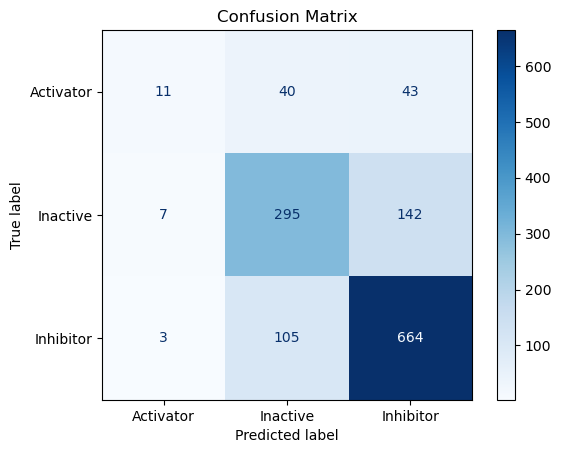

In [31]:
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [1]:
import pickle

In [32]:
# Salvar o modelo treinado em um arquivo .pkl
with open('lgbm_model.pkl', 'wb') as file:  # <- Adicionada seção para salvar o modelo
    pickle.dump(lgbm, file)

# Opcionalmente, você pode salvar o LabelEncoder e o Scaler, caso necessário
with open('label_encoder.pkl', 'wb') as file:  # <- Seção para salvar o LabelEncoder
    pickle.dump(le, file)

Use oversampling to compensate for imbalanced data

In [33]:
from imblearn.over_sampling import RandomOverSampler

In [34]:
ros = RandomOverSampler()
resample_X, resample_y = ros.fit_resample(train_X,train_y)

In [35]:
pd.Series(train_y).value_counts()

label
2    2268
1    1415
0     246
Name: count, dtype: int64

In [36]:
pd.Series(resample_y).value_counts()

label
2    2268
1    2268
0    2268
Name: count, dtype: int64

In [37]:
resample_lgbm = LGBMClassifier()
resample_lgbm.fit(resample_X, resample_y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9701
[LightGBM] [Info] Number of data points in the train set: 6804, number of used features: 1890
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier()

In [38]:
resample_pred = resample_lgbm.predict_proba(test_X)
roc_auc_score(test_y,resample_pred,multi_class='ovr',average='macro')

0.7666694189953551

In [39]:
sns.set_style("white")
sns.set_context('talk')

In [40]:
classifiers = [lgbm, resample_lgbm]
titles = ["Standard", "Oversampled"]

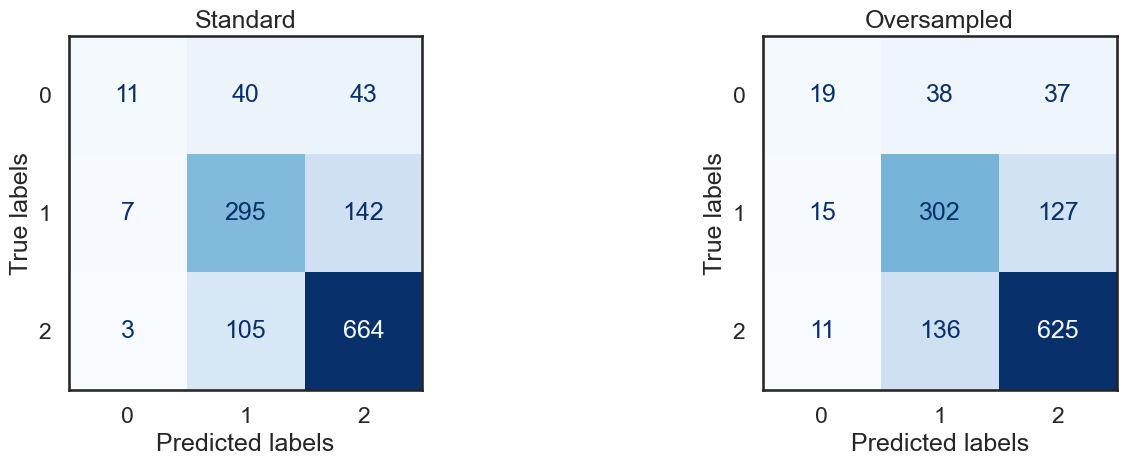

In [41]:
# Criar a figura e os eixos
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Iterar sobre os classificadores e eixos
for cls, ax, title in zip(classifiers, axes, titles):
    # Calcular as previsões
    y_pred = cls.predict(test_X)
    
    # Identificar os rótulos únicos em test_y e y_pred
    true_labels = np.unique(test_y)
    pred_labels = np.unique(y_pred)
    
    # Ajustar a lista de rótulos para incluir apenas rótulos presentes
    labels_to_use = np.unique(np.concatenate((true_labels, pred_labels)))
    
    # Calcular a matriz de confusão
    cm = confusion_matrix(test_y, y_pred, labels=labels_to_use)
    
    # Criar o display da matriz de confusão
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_to_use)
    
    # Plotar a matriz de confusão
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    
    # Configurar título
    ax.title.set_text(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

# Ajustar o layout
plt.tight_layout()
plt.show()

In [42]:
res = []
for i in tqdm(range(0,10)):
    # split the data into training and test sets
    train, test = train_test_split(data_df)
    train_X = np.stack(train.desc)
    train_y = train.label
    test_X = np.stack(test.desc)
    test_y = test.label
    # Create the standard model
    lgbm = LGBMClassifier()
    lgbm.fit(train_X,train_y)
    pred = lgbm.predict_proba(test_X)
    auc = roc_auc_score(test_y,pred,multi_class='ovo',average='macro')
    # Create the resampled model
    resample_lgbm = LGBMClassifier()
    resample_X, resample_y = ros.fit_resample(train_X,train_y)
    resample_lgbm.fit(resample_X, resample_y)
    resample_pred = resample_lgbm.predict_proba(test_X)
    resample_auc = roc_auc_score(test_y,resample_pred,multi_class='ovr',average='macro')
    res.append([auc, resample_auc])

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9206
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1634
[LightGBM] [Info] Start training from score -2.816555
[LightGBM] [Info] Start training from score -1.026925
[LightGBM] [Info] Start training from score -0.541144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9738
[LightGBM] [Info] Number of data points in the train set: 6861, number of used features: 1900
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013895 s

In [43]:
res = np.array(res)
res_df = pd.DataFrame(res,columns=["Standard","Oversampled"])

In [44]:
res_df.head()

,Standard,Oversampled
0,0.741132,0.775015
1,0.739418,0.775842
2,0.726125,0.761258
3,0.752691,0.769903
4,0.744932,0.780184


In [45]:
melt_df = res_df.melt()
melt_df.columns = ["Method","AUC"]
melt_df

,Method,AUC
0,Standard,0.741132
1,Standard,0.739418
2,Standard,0.726125
3,Standard,0.752691
4,Standard,0.744932
5,Standard,0.757522
6,Standard,0.747251
7,Standard,0.738798
8,Standard,0.732707
9,Standard,0.745802


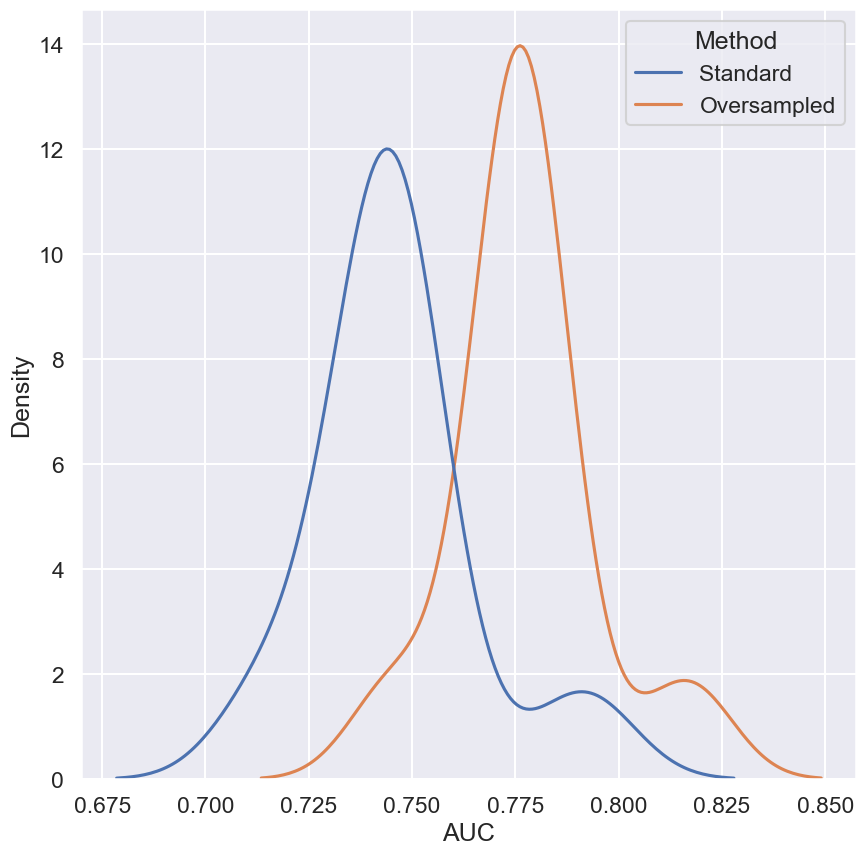

In [94]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_context('talk')
sns.kdeplot(x="AUC",hue="Method",data=melt_df);

In [48]:
from pingouin import wilcoxon, plot_paired

c:\Users\lucas\anaconda3\Lib\site-packages\pingouin\plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


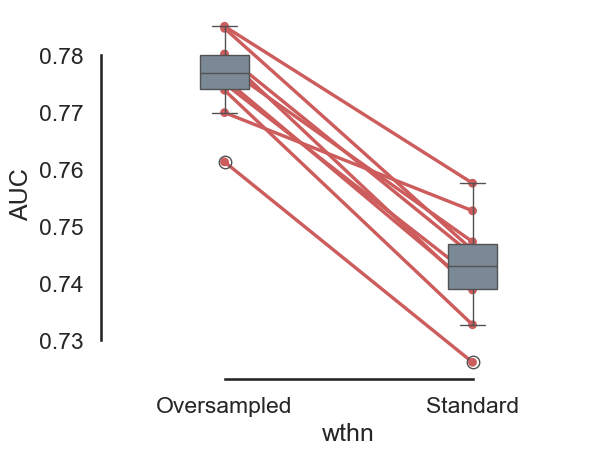

In [49]:
melt_df['cycle'] = list(range(0,10))+list(range(0,10))
plot_paired(data=melt_df,dv="AUC",within="Method",subject="cycle");

In [50]:
wilcoxon(res_df.Standard,res_df.Oversampled)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,0.0,two-sided,0.001953,-1.0,0.0
